# Land cover classification using sentinel 2 Imagery: a glance of how to work under static modellling

This paper attempts to document the process of supervised classification of one satelite image of the sensor sentinel 2 using COS data under the environment of python. In this sense, the results are going to be used as baseline of a multitemporal analysis of the year 2017. This reference look for evaluating performance of a static model using different assumptions about how to integrate COS training data in the classification task. Moreover, this performance will lead to set challenges and possible improvements that the integration of the temporal domain may reach out in this thesis. 


## Importing lulc package

lulc is a package under construction composed for different modules that look for reducing complexity in the proposed scripts. lulc makes specific use of **osgeo**, **numpy** and **matplotlib** packages. Users that are interested in what is going on under the hood of each module can have a glanse of the package directly in github. 

In [46]:
import lulc

## Importing Imagery

Well, for this task I have chosen one image of the central of Portugal for the date July 24 of 2017. This choice depended on the best accuracies obtained after having made the classifications for all the imagery available (see main document thesis). Besides that, the image originally come in level 1C, this mean that previously to this paper, we have implemented the readiometric and atmospheric corrections by using the plugin of ESA called "Sen2Cor". Therefore, having the image in level 2A, which means images wich reflectance bottom Of Atmosphere (BOA), we set out to import the bands. 

In [3]:
#importing libraries
from osgeo import gdal, ogr
import os
import numpy as np
import lulc
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#path where the image is located
raster_path = r'/home/user/Documents/TESISMASTER/IMAGES/TO_PROCESS_10m/Autumn/IM_20170729'
list_raster = [os.path.join(raster_path,i) for i in os.listdir(raster_path) if i.endswith('.tiff') or i.endswith('.jp2')]
list_raster.sort()
#names of the raster_dataset
list_label_raster = [i.split('_')[-2] for i in os.listdir(raster_path) if i.endswith('.tiff') or i.endswith('.jp2')]
list_label_raster.sort()
print('Bands in process')
print(list_label_raster)

Bands in process
['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12', 'B8A', 'NDVI', 'ZDEM', 'ZSLOPE']


As you may have noticed we account with 13 bands that have the same 10 meters of spatial resolution, so that before to this paper we have also implemented resampling of the available 20 meters bands and a digital elevation model of 30 meters resolution. B02: Blue; B03:Green; B04: Red, B05,B06,B07: Vgetation red edge; B08: NIR; B11, B12: SWIR; B8A: Narrow NIR; NDVI; ZDEM; ZSLOPE.  

In [4]:
bands_data = []
for i in list_raster:
    raster_dataset = gdal.Open(i,gdal.GA_ReadOnly)
    #geotransformation
    gt = raster_dataset.GetGeoTransform()
    proj = raster_dataset.GetProjectionRef()
    #Importing bands as a set of arrays
    n_bads = raster_dataset.RasterCount
    band =  raster_dataset.GetRasterBand(1)
    bands_data.append(band.ReadAsArray())
    print('Band: ', i, ' is imported')

#stacking layers
bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape
print(bands_data.shape)

Band:  /home/user/Documents/TESISMASTER/IMAGES/TO_PROCESS_10m/Autumn/IM_20170729/IM_20170729_B02_10m.jp2  is imported
Band:  /home/user/Documents/TESISMASTER/IMAGES/TO_PROCESS_10m/Autumn/IM_20170729/IM_20170729_B03_10m.jp2  is imported
Band:  /home/user/Documents/TESISMASTER/IMAGES/TO_PROCESS_10m/Autumn/IM_20170729/IM_20170729_B04_10m.jp2  is imported
Band:  /home/user/Documents/TESISMASTER/IMAGES/TO_PROCESS_10m/Autumn/IM_20170729/IM_20170729_B05_10m.tiff  is imported
Band:  /home/user/Documents/TESISMASTER/IMAGES/TO_PROCESS_10m/Autumn/IM_20170729/IM_20170729_B06_10m.tiff  is imported
Band:  /home/user/Documents/TESISMASTER/IMAGES/TO_PROCESS_10m/Autumn/IM_20170729/IM_20170729_B07_10m.tiff  is imported
Band:  /home/user/Documents/TESISMASTER/IMAGES/TO_PROCESS_10m/Autumn/IM_20170729/IM_20170729_B08_10m.jp2  is imported
Band:  /home/user/Documents/TESISMASTER/IMAGES/TO_PROCESS_10m/Autumn/IM_20170729/IM_20170729_B11_10m.tiff  is imported
Band:  /home/user/Documents/TESISMASTER/IMAGES/TO_PR

## Importing Training data

The training data for this classification corresponds to COS after having implemented the analysis of outliers using NDVI over the time (see analysis of outliers in COS data).Therefore, we account with a training dataset composed by 13400 samples categorized by 15 different classes. 1: Sealed; 2:Olive-trees; 3: Holm and cork trees; 4: Eucalytus trees; 5: Coniferous trees; 6: Rice fields; 7: Orchards. 8:Non-vegetated; 9: Wetlands; 10: Water; 11:Herbaceus-periodic; 12:Herbaceous-permanent; 13: Natural-herbaceous; 14: Bushes and shrubs; 15: Vineyard

In [62]:
train_path = r'/home/user/Documents/TESISMASTER/VECTOR/Analysis_outliers/Model_IQR'
#Importing shapefiles
print('Calling shapefiles')
shapefiles = [os.path.join(train_path,i) for i in os.listdir(train_path) if i.endswith('.shp')]
shapefiles.sort()
labels_classes = [i.split('.')[0] for i in os.listdir(train_path) if i.endswith('.shp')]
labels_classes.sort()
print(labels_classes)

#Rasterizing the training data
labeled_pixels= lulc.vectors_to_raster(shapefiles, rows, cols, gt , proj)
#selecting training data,
is_train= np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]
print(training_samples.shape)

Calling shapefiles
['1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']
(13392, 13)


## Explorative analysis

The following figure presents the scatter plot of the less correlated bands of the dataset. As an example we ilustrate the relation for tree different labels (1: Sealed, 6: Rice fields and 4: Eucaliptus tress). Essentially, the graphic is showing in the bottom left and upper rigth the dispersion among the values of the 4 bands, and in the diagonal the histograms per band. Each realation also depicts the concentration of points where each class is located, so that we can define which bands may facilitate the correct separation of land cover types.

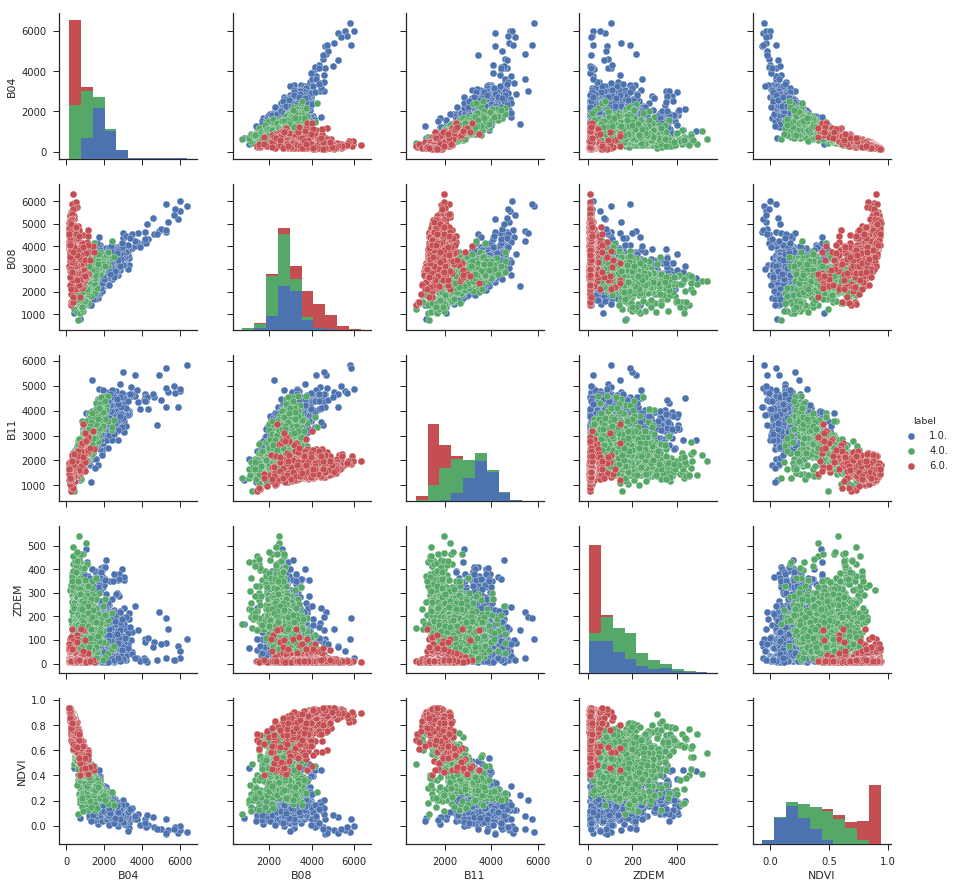

In [63]:
import seaborn as sns
#transforming array to pandas format dataframe
df = pd.DataFrame(training_samples , columns = list_label_raster)
df['label'] = [str(i) +'.' for i in training_labels]
#subsetting the data frame
index = np.where(df['label'].isin(['1.0.','6.0.','4.0.']))[0]
df_query = df.loc[index,['B04','B08','B11','ZDEM','NDVI','label']]
sns.set(style='ticks')
g = sns.pairplot(df_query,hue = "label")


## Defining test and training data

The dataset is divided on two groups by using random assigment, one for training the model with random forest and another to test the performance of the clasification.

In [7]:
tr, te = lulc.stratified_sampling(training_labels,prob = (0.7,0.3))
#train
train_samples = training_samples[tr,]
train_labels = training_labels[tr,]
#test
test_samples = training_samples[te,]
test_labels = training_labels[te,]

## Tunning parameters random forest

The training data here is used to train and validate the model, so that I will implementd 2 fold cross validation mainting the proportions for each class to tune the parameters of random forest

Tunning parameters


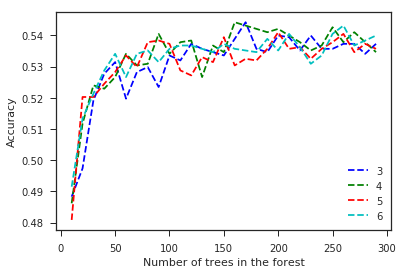

done


In [131]:
print("Tunning parameters")
lulc.tunning_parameters_RF(train_samples, train_labels,prob = (0.8,0.2))
print('done')

We have tunned two parameters of the random forest classifier, the number of trees in the forest and the number of variables to randomly selected per iteration. Therefore, the best accuracies stabilize in the region of 100 trees and forward. Besides that, in average the number of variables that improve the classification is between 3 and 4. 

## Decision tree Classifier
Once tunning the parameters we have to set up the classifier using as reference 100 number of trees in the forest by iteration and 4 variables per selection.

In [8]:
#Seeting the classifier according with the previous parameters
classifier= RandomForestClassifier(n_estimators=100,min_samples_split = 4)
classifier.fit(train_samples, train_labels)
result = classifier.predict(test_samples)
print('done')

done


## Confusion Matrix
To describe the performance of the classification we make use of the confusion matrix. Essentially, this table compares a set of labels of a test data for which the true labes are known. 

Normalized confusion matrix


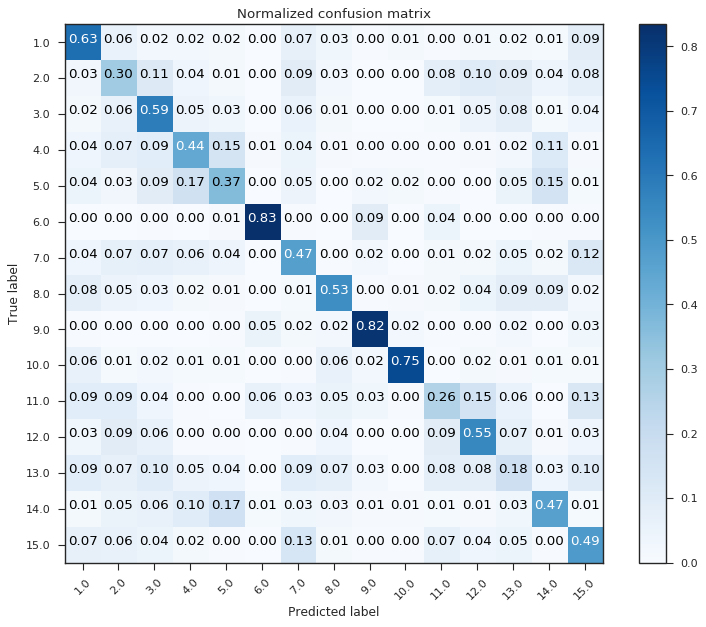

In [20]:
cm = confusion_matrix(test_labels,result,labels = np.unique(test_labels))
np.set_printoptions(precision=2)
plt.figure(figsize = (10,8), dpi=80)
lulc.plot_confusion_matrix(cm, classes=np.unique(test_labels), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

1: Sealed; 2:Olive-trees; 3: Holm and cork trees; 4: Eucalytus trees; 5: Coniferous trees; 6: Rice fields; 7: Orchards. 8:Non-vegetated; 9: Wetlands; 10: Water; 11:Herbaceus-periodic; 12:Herbaceous-permanent; 13: Natural-herbaceous; 14: Bushes and shrubs; 15: Vineyard

As we noticed in the vignette of analysis of outliers using NDVI, where the forest and seminatural classes did not depict differences neither in their tendencies or their dispersion over the year, we already expected a low performance and a strong difusion on their classification (Holm and cork tress, Eucalyptus trees, Coniferus trees). Likewise, herbaceus periodic was part of the trajectories with a high variability in the NDVI variance over the year, so that we also expected low accuracy for this LCLU type since as the variance increases the region of variabilty start overlaping with other classes.

In [136]:
print('Overal Accuracy: ', accuracy_score(result, test_labels))

Overal Accuracy:  0.5314285714285715


A supervised classification considering 15 classes and 13 variables leads to a overall acuracy of 0.53. This value will be a reference for the classification that consider the temporal domain.

Text(0.5, 1.0, 'level of importance variables random forest')

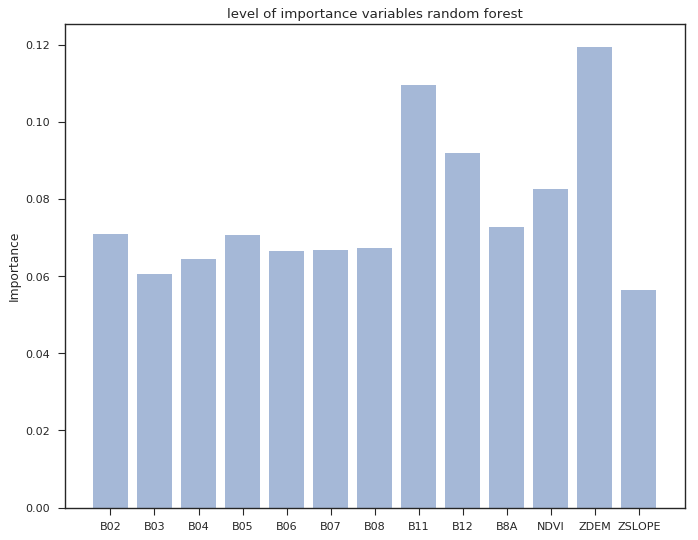

In [149]:
importance = classifier.feature_importances_
y_pos = np.arange(len(importance))
plt.figure(figsize = (10,8), dpi=80)
plt.bar(y_pos,importance,align ='center',alpha=0.5)
plt.xticks(y_pos,list_label_raster)
plt.ylabel("Importance")
plt.title('level of importance variables random forest')

Finally, the previous graphic depicts the level of importance of each variable in the classification task. Therefore, the better scores are associated with the bands B11 and B12 that represent the short wave infrared spectral range, the NDVI and the digital elevation model. 

## Conclusions
This document defined the process of how to run a supervised clasification in Python using sentinel 2 imagery and COS data. We have defined which bands are given more information for this task, as well as which classes still represent a challenge in the classification task.
